In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- Split image into blocks
- Calculate DCT transformation matrix for each block
- Sample S pixels from each image block

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
import cv2
from google.colab.patches import cv2_imshow
import math

# split an image into blocks of size (block_size * block_size)
def split_image(img, block_size):
  shape = img.shape
  x_len = shape[0]
  y_len = shape[1]

  blocks = []
  for i in range(0, x_len, block_size):
    for j in range(0, y_len, block_size):
      blocks.append( img[i:i+block_size, j:j+block_size] )

  return blocks, x_len, y_len

# calculate the DCT transformation matrix of each block (same for blocks that has the same size)
def dctmtx(block_size):
  D = fftpack.dct(np.eye(block_size), norm='ortho', axis=0)
  T = np.transpose(np.kron(D, D))
  return T

# show image to output
def show_image(img):
  img = np.uint8(img)
  cv2_imshow(img)

# sample (sample_size) pixels from an image block, and sample the corresponding rows from its DCT matrix
# construct the sample data in the form of (sample DCT matrix | sample pixels)
def sample(block, block_size, sample_size, dctmtx):
  sample_index = np.random.choice(block_size*block_size, sample_size, replace = False)
  sample_block = np.expand_dims(block.flat[sample_index], axis = 1)
  sample_dctmtx = dctmtx[sample_index, :]
  data = np.hstack((sample_dctmtx,sample_block))
  return sample_index, sample_block, sample_dctmtx, data

# construct the sampled image (damaged image) by assigning the pixel intensity at the non-sample index to 0
def create_damage_block(sample_index, block, block_size):
  temp_block = block
  damage_block = temp_block.flatten()
  non_sample_index = list(set(range(block_size*block_size))-set(sample_index))
  damage_block[non_sample_index] = 0
  return non_sample_index, damage_block

# create a mask image block (empty block) of size (block_size * block_size), update the block with another block
def populate_block(block, block_size):
  mask = np.zeros((block_size*block_size))
  for i, pixel in enumerate(block):
    mask[i] = pixel
  return mask.reshape((block_size, block_size))

# reconstruct an image by all of its block pieces
# concatenate the reconstructed image blocks into block-rows, and then concatenate the block-rows
def reconstruction(image_blocks, block_per_row, block_size):
  img_rows = []
  for i, block in enumerate(image_blocks):
    if i%block_per_row == 0:
      base_img = populate_block(block, block_size)
    else:
      curr_block = populate_block(block, block_size)
      row_img = np.concatenate([base_img, curr_block], axis=1)
      base_img = row_img
      if (i+1)%block_per_row == 0:
        img_rows.append(row_img)
        row_img = None

  for i,row_img in enumerate(img_rows):
    if i == 0:
      new_img = img_rows[i]
    elif i < len(img_rows):
      new_img = np.concatenate((new_img, img_rows[i]),axis=0)

  return new_img

# recover a damaged image by substituting the missing pixels by the pixels that are predicted by the model
def recover_image(missing_index, original_block, predict_block):
  temp_block = original_block
  temp_block = temp_block.flatten()
  for i in missing_index:
    temp_block[i] = predict_block[i]
  return temp_block

# measure the quality of recovered image
# mean square error between recovered image and the original image
def quality_measure(old_img, new_img):
  flat_old = old_img.flatten()
  flat_new = new_img.flatten()
  error = mean_squared_error(flat_old, flat_new)
  return error


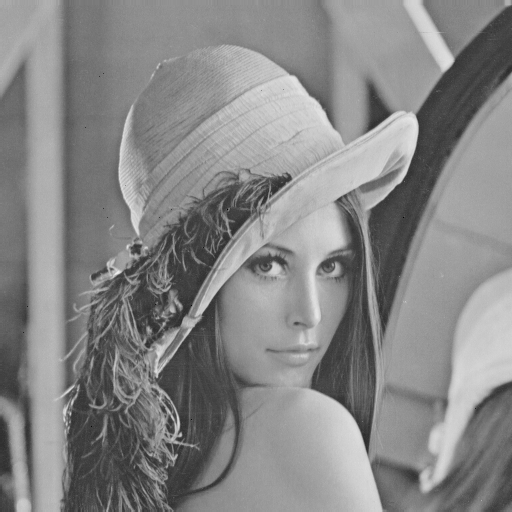

image size:  (512, 512)
number of blocks:  1024
size of sampled image:  (1024, 150, 1)
size of sampled dct matrix:  (1024, 150, 256)
size of dataset:  (1024, 150, 257)
size of damaged image:  (1024, 256)


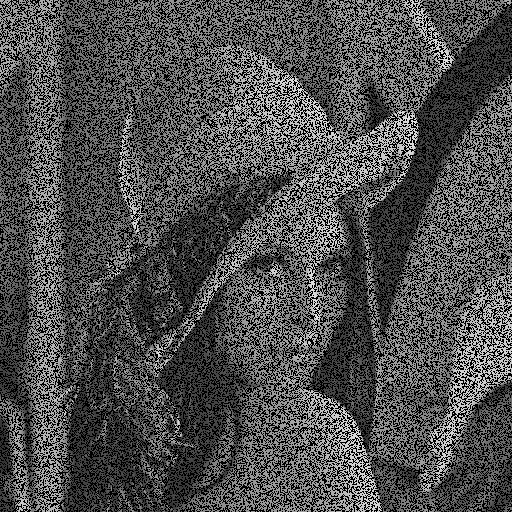

True

In [3]:
# read image and show the original image
# access the image that saved in your drive, the path might be different
img = cv2.imread('/content/drive/My Drive/Colab Notebooks/MP_image/lena.bmp', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('/content/drive/My Drive/Colab Notebooks/MP_image/fishing_boat.bmp', cv2.IMREAD_GRAYSCALE)
show_image(img)

# split image into blocks
# K = 8
K = 16
blocks, W, H = split_image(img, K)
num_blocks = len(blocks)
print('image size: ', img.shape)
print('number of blocks: ', num_blocks)

# calculate the DCT transformation matrix for each image block
T = dctmtx(K)

# sample image
S = 150
sample_blocks = []
sample_dctmtxs = []
dataset = []
missing_indices = []
damage_blocks = []

for i in range(num_blocks):
  sample_index, sample_block, sample_dctmtx, data = sample(blocks[i], K, S, T)
  missing_index, damage_block = create_damage_block(sample_index, blocks[i], K)

  sample_blocks.append(sample_block)
  sample_dctmtxs.append(sample_dctmtx)
  dataset.append(data)
  damage_blocks.append(damage_block)
  missing_indices.append(missing_index)

print('size of sampled image: ', np.shape(np.array(sample_blocks)))
print('size of sampled dct matrix: ', np.shape(np.array(sample_dctmtxs)))
print('size of dataset: ', np.shape(np.array(dataset)))
print('size of damaged image: ', np.shape(np.array(damage_blocks)))

# rebuild sampled image and show the damaged image
block_per_row = img.shape[1]/K
damage_img = reconstruction(damage_blocks, block_per_row, K)
show_image(damage_img)
cv2.imwrite('sampled_image_150.jpeg', damage_img)


- Select different lamda in range (1e-6, 1e+6)
- Random split train and test set for cross-validation(20 iter)
- LASSO regression fitting


In [0]:
import random
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

dataset_cp = dataset
all_lambda = []
lambda_range = np.logspace(-6, 6, 26)

for i in range(num_blocks):
  print('block ', i)
  min_mse = 20000
  best_lambda = lambda_range[0]

  for a in lambda_range:
    MSE = []
    for j in range(20):
      X_train, X_test, y_train, y_test = train_test_split(dataset_cp[i][:, 0:K*K], dataset_cp[i][:,-1], test_size = math.floor(S/6))
      lasso = Lasso(alpha = a, max_iter= 1e4)
      lasso.fit(X_train, y_train)
      y_hat = lasso.predict(X_test)
      mse = mean_squared_error(y_test, y_hat)
      MSE.append(mse)
    mean_mse = np.mean(MSE)
    if mean_mse < min_mse:
      min_mse = mean_mse
      best_lambda = a
  all_lambda.append(best_lambda)
  

- train each image block with the best lamda
- calculate the model parameter (DCT coefficient)

In [0]:
dataset_cp = dataset
dct_coef = []
intercepts = []

for i in range(num_blocks):
  X = dataset_cp[i][:, 0:K*K]
  Y = dataset_cp[i][:,-1]
  lasso = Lasso(alpha = all_lambda[i], max_iter= 1e4)
  lasso.fit(X, Y)
  intercept = lasso.intercept_
  coeffs = lasso.coef_
  intercepts.append(intercept)
  dct_coef.append(coeffs)

- predict the missing pixels using the DCT coefficient
- recover damage image and show the recovered image
- calculate the recovery error for the recovered image


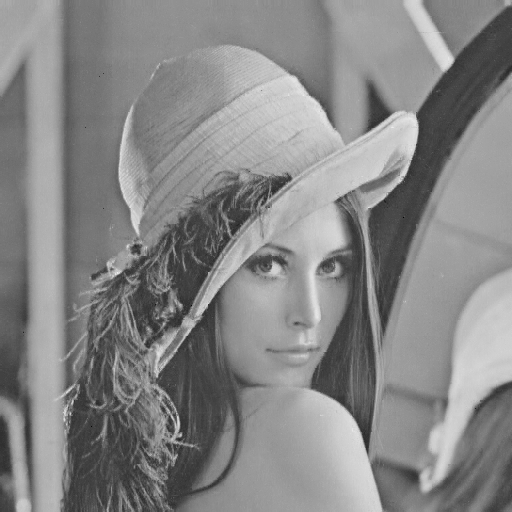

error between the recover image and original image =  16.168926239013672


In [6]:
reconstruct_blocks = []

for i in range(num_blocks):
  predict_block = T.dot(dct_coef[i])+intercepts[i]
  reconstruct_block = recover_image(missing_indices[i], blocks[i], predict_block)
  reconstruct_blocks.append(reconstruct_block)

new_img = reconstruction(reconstruct_blocks, block_per_row, K)
show_image(new_img)
cv2.imwrite('recover_image_150.jpeg', new_img)

recovery_error = quality_measure(img, new_img)
print('error between the recover image and original image = ', recovery_error)

- apply median filter to the recovered image and show the image afterwards
- calculate the recovery error for the recovered image with median filter

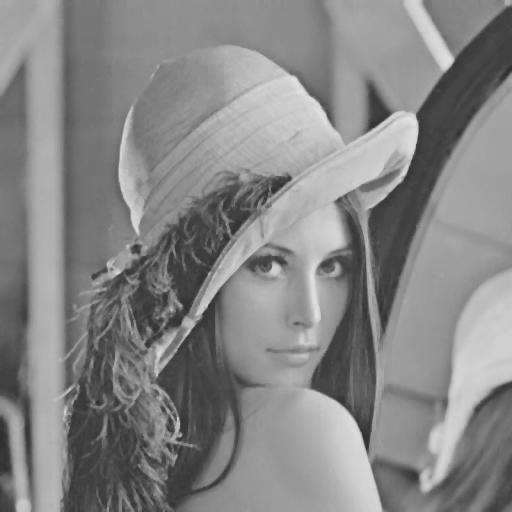

error between the recover image(with median filter) and original image =  14.111858367919922


In [7]:
new_img = np.uint8(new_img)
img_median = cv2.medianBlur(new_img, 3)
show_image(img_median)
cv2.imwrite('recover_image_median_filter_150.jpeg', img_median)

recovery_error = quality_measure(img, img_median)
print('error between the recover image(with median filter) and original image = ', recovery_error)